# Homework 2: Fine-tuning & Prompting of LMs (51 points)

The focus of this homework is on one prominent fine-tuning technique -- reinforcement learning from human feedback -- and on critically thinking about prompting techniques and papers about language models

### Logistics

* submission deadline: June 3rd th 23:59 German time via Moodle
  * please upload a **SINGLE .IPYNB FILE named Surname_FirstName_HW2.ipynb** containing your solutions of the homework.
* please solve and submit the homework **individually**!
* if you use Colab, to speed up the execution of the code on Colab, you can use the available GPU (if Colab resources allow). For that, before executing your code, navigate to Runtime > Change runtime type > GPU > Save.


## Exercise 1: Advanced prompting strategies (16 points)

The lecture discussed various sophisticated ways of prompting language models for generating texts. Please answer the following questions about prompting techniques in context of different models, and write down your answers, briefly explaining them (max. 3 sentences). Feel free to actually try out some of the prompting strategies to play around with them and build your intuitions.

> Consider the following language models:
> * GPT-4, Qwen-2.5-Coder-32B, Mistral-24B-Instruct, Llama-2-70b-base.
>  
> Consider the following prompting / generation strategies:
> * tree-of-thought reasoning, zero-shot chain-of-thought prompting, few-shot prompting, self-reflection prompting.
>
> For each model:
> * which strategies do you think work well, and why?
>
> For each prompting strategy:
> * Name an example task or context, and model, in which you would think they work best. Briefly justify why.

* **GPT-4**: Works well with all strategies because it has undergone extensive instruction tuning and exhibits strong generalization.

* **Qwen-2.5-Coder-32B**: Best with few-shot prompting for coding tasks. It's tuned for code and benefits from clear examples. Less good with freeform reasoning.


* **Mistral-24B-Instruct**: Good with few-shot and zero-shot CoT. It's trained to follow instructions, so it does well when the task is clear or shown in examples.


* **LLaMA-2-70B-base**: Performs decently with few-shot and zero-shot CoT. It's not instruction-tuned, so it needs help from examples to understand the task.

---

**Tree-of-Thought Reasoning**

Prompt: Should I study at night or in the morning? List both options, their pros and cons, and help me choose based on focus and energy.

GPT-4 works best as it has strong reasoning abilities and a large context window, which allows it to explore multiple options. It's also been trained to handle multi-step tasks with structure and logic.

**Zero-Shot Chain-of-Thought Prompting**

Task: "Is 2 a prime number? Explain step by step."

GPT-4 or Mistral-24B-Instruct are good because they can reason clearly without needing examples.

**Few-Shot Prompting**

Prompt: Code generation with 1-2 examples.

Qwen-2.5-Coder performs well because it learns from the examples and sticks to the format.

**Self-Reflection Prompting**

Prompt: Write a short paragraph about why climate change is an important issue. Rewrite and improve the paragraph based on your reflection.

GPT-4 is ideal because it can reliably critique and improve its own output.



## Exercise 2: RLHF for summarization (15 points)

In this exercise, we want to fine-tune GPT-2 to generate human-like news summaries, following a procedure that is very similar to the example of the movie review generation from [sheet 4.1](https://cogsciprag.github.io/Understanding-LLMs-course/tutorials/04a-finetuning-RL.html). The exercise is based on the paper by [Ziegler et al. (2020)](https://arxiv.org/pdf/1909.08593).

To this end, we will use the following components:
* in order to initialize the policy, we use GPT-2 that was already fine-tuned for summarization, i.e., our SFT model is [this](https://huggingface.co/gavin124/gpt2-finetuned-cnn-summarization-v2)
* as our reward model, we will use a task-specific reward signal, namely, the ROUGE score that evaluates a summary generated by a model against a human "gold standard" summary.
* a dataset of CNN news texts and human-written summaries (for computing the rewards) for the fine-tuning which can be found [here](https://huggingface.co/datasets/abisee/cnn_dailymail). Please note that we will use the *validation* split because we only want to run short fine-tuning.

**NOTE:** for building the datset and downloading the pretrained model, ~4GB of space will be used.

> **YOUR TASK:**
>
> Your job for this task is to set up the **GRPO-based** training with the package `trl`, i.e., the set up step 3 of [this](https://cdn.openai.com/instruction-following/draft-20220126f/methods.svg) figure. GRPO (Group Relative Policy Optimization) is an RL algorithm that was proposed by [Shao et al. (2024)](https://arxiv.org/pdf/2402.03300) for the DeepSeek math model.
> 1. Please complete the code or insert comments what a particular line of code does below where the comments says "#### YOUR CODE / COMMENT HERE ####". For this and for answering the questions, you might need to dig a bit deeper into the working of GRPO, the algorithm that we are using for training. You can find relevant information on the implementation, e.g., [here](https://huggingface.co/docs/trl/main/en/grpo_trainer).
> 2. To test your implementation, you can run the training for ~250 steps, but you are NOT required to train the full model since it will take too long. We will NOT be evaluating your submission based on the performance of the model.
> 3. Answer the questions below.

In [1]:
 !pip install gcsfs==2025.3.0 fsspec==2025.3.0 accelerate==1.6.0 trl==0.17.0 evaluate rouge_score datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00

In [2]:
# import libraries
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import AutoTokenizer
from datasets import load_dataset

from trl import (
    GRPOTrainer,
    GRPOConfig,
)
import evaluate

In [3]:
#### sets up the training configuration for the GRPO trainer ####
config = GRPOConfig(
    #### controls how fast the model learns. Smaller values mean slower, more stable learning. #####
    learning_rate=1.41e-5,
    ####  number of training steps. ####
    max_steps=250,
    #### number of samples to train on at once, per device ####
    per_device_train_batch_size=8,
    #### number of output the model should generate per input during training ####
    num_generations=8,
    num_train_epochs=1
    ,
    #### how often to log training progress. Here we are logging every step ####
    logging_steps=1,
    #### we don't want to send logs to any external tracking tools like WandB ####
    report_to="none",
)

We load the CNN dataset and truncate the texts to 512 tokens, because we don't want the training to be too memory heavy and we want to have "available" some tokens for the generation (GPT-2's context window size is 1024). Then we tokenize each text and pad it.

In [26]:
def build_dataset(
        model_name,
        dataset_name="abisee/cnn_dailymail"
    ):
    """
    Build dataset for training. This builds the dataset from `load_dataset`.

    Args:
        model_name (`str`):
            The name of the SFT model to be used, so that the matchin tokenizer can be loaded.
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    # load the datasets
    ds = load_dataset(dataset_name, '1.0.0', split="validation")

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(
            sample["article"],
            return_tensors="pt",
            max_length=512,
            truncation=True,
            padding="max_length"
        )
        # get the truncated natural language text, too
        sample["prompt"] = tokenizer.decode(
                                    tokenizer.encode(sample["article"], max_length=512, truncation=True)
                                    )
        sample["ground_truth"] = sample["highlights"]
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds


In [27]:
sample = dataset[0]
print("Prompt:", sample["prompt"])
print("Ground truth:", sample["ground_truth"])
print("Input IDs:", sample["input_ids"])


Prompt: (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medical

In [28]:
# use tokenizer from HF named: "gavin124/gpt2-finetuned-cnn-summarization-v2"
# build the dataset
dataset =  build_dataset(model_name="gavin124/gpt2-finetuned-cnn-summarization-v2")

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [29]:
# inspect a sample of the dataset
print(dataset[0])

{'article': '(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don\'t know, but the fact that so many people can have a life extension, that\'s pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I\'m just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard\'s gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacifi

We load the tokenizer corresponsing to the SFT GPT2 model that we already used above to pretokenize the dataset.

In [30]:
tokenizer = AutoTokenizer.from_pretrained("gavin124/gpt2-finetuned-cnn-summarization-v2")

tokenizer.padding_side='left'
tokenizer.pad_token = tokenizer.eos_token

Below, we define our custom reward function:

In [31]:
# rouge = evaluate.load("rouge")

# def reward_fn(
#         output: list[str],
#         original_summary: list[str]
#     ):
#     """
#     Computes a reward score for each generated output based on how similar it is
#     to the original summary using the ROUGE-1 metric.
#     """
#     scores = []
#     for o, s in list(zip(output, original_summary)):
#       score = rouge.compute(predictions=[o.strip()], references=[s])["rouge1"]
#       scores.append(torch.tensor(score))

#     return scores

In [37]:
def reward_fn(prompts, completions, **kwargs):
    """
    Computes a reward score for each generated completion based on how similar it is
    to the original summary using the ROUGE-1 metric.

    Args:
        prompts: List of input prompts
        completions: List of generated summaries
        **kwargs: Additional keyword arguments, including 'ground_truth'
    """
    scores = []
    ground_truths = kwargs.get('ground_truth', [])

    for completion, ground_truth in zip(completions, ground_truths):
            score = rouge.compute(predictions=[completion.strip()], references=[ground_truth])["rouge1"]
            scores.append(torch.tensor(score))

    return scores


Nest, we set up the trainer:

In [38]:
#### create the trainer for GRPO ####
grpo_trainer = GRPOTrainer(
    args=config, # training configuration (like learning rate, batch size, etc.)
    model="gavin124/gpt2-finetuned-cnn-summarization-v2", # use the GPT-2 model fine-tuned for summarization on the CNN dataset
    reward_funcs=reward_fn, # reward function that gives a score to each generated summary
    processing_class=tokenizer, # tokenizer to preprocess the inputs before training
    train_dataset=dataset, # training dataset
)

In [39]:
grpo_trainer.train()

Step,Training Loss
1,0.219200
2,0.041500
3,0.026100
4,0.013500
5,0.256900
6,0.020700
7,0.266100
8,0.286100
9,5.940100
10,0.073600


TrainOutput(global_step=250, training_loss=4.207985516555822, metrics={'train_runtime': 1485.3876, 'train_samples_per_second': 1.346, 'train_steps_per_second': 0.168, 'total_flos': 0.0, 'train_loss': 4.207985516555822})

In [ ]:
#### YOUR CODE HERE: plot the loss and the rewards of the model training by accessing the trainer logs under grpo_trainer.state.log_history ####
#### YOUR COMMENT HERE: do the plots indicate a trend towards successful training? ####


In [45]:
grpo_trainer.state.log_history

[{'loss': 0.2192,
  'grad_norm': 3.041290044784546,
  'learning_rate': 1.41e-05,
  'num_tokens': 5595.0,
  'completions/mean_length': 187.375,
  'completions/min_length': 108.0,
  'completions/max_length': 256.0,
  'completions/clipped_ratio': 0.25,
  'completions/mean_terminated_length': 164.5,
  'completions/min_terminated_length': 108.0,
  'completions/max_terminated_length': 238.0,
  'rewards/reward_fn/mean': 0.2500512897968292,
  'rewards/reward_fn/std': 0.03991682454943657,
  'reward': 0.2500512897968292,
  'reward_std': 0.039916832000017166,
  'kl': 0.36980023980140686,
  'clip_ratio/low_mean': 0.0,
  'clip_ratio/low_min': 0.0,
  'clip_ratio/high_mean': 0.0,
  'clip_ratio/high_max': 0.0,
  'clip_ratio/region_mean': 0.0,
  'epoch': 7.480550568521843e-05,
  'step': 1},
 {'loss': 0.0415,
  'grad_norm': 3.2266385555267334,
  'learning_rate': 1.40436e-05,
  'num_tokens': 9091.0,
  'completions/mean_length': 99.0,
  'completions/min_length': 35.0,
  'completions/max_length': 256.0,
  

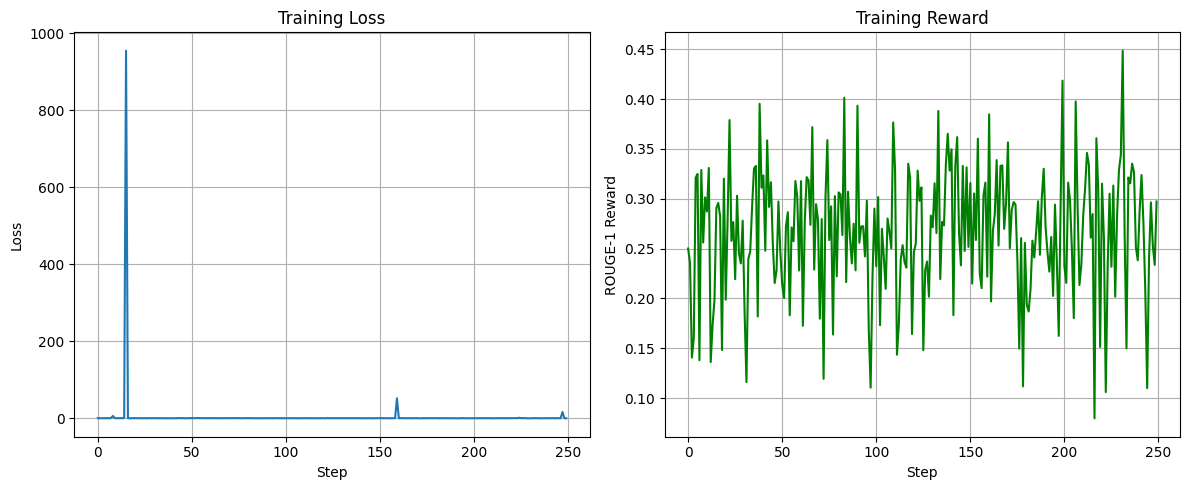

In [44]:
import matplotlib.pyplot as plt


losses = [log["loss"] for log in grpo_trainer.state.log_history if "loss" in log]
rewards = [log["reward"] for log in grpo_trainer.state.log_history if "reward" in log]
steps = list(range(len(losses)))

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(steps, losses, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# Plot Reward
plt.subplot(1, 2, 2)
plt.plot(steps, rewards, label="Reward", color="green")
plt.xlabel("Step")
plt.ylabel("ROUGE-1 Reward")
plt.title("Training Reward")
plt.grid(True)

plt.tight_layout()
plt.show()


**Comment**:
The loss drops sharply after an initial spike, suggesting instability or fast overfitting. The reward fluctuates a lot and doesn't show clear improvement, so the model isn't learning consistently. This indicates the training wasn't very successful.

> **QUESTIONS:**
>
> 1. Suppose the plots of rewards below show training metrics for different runs of the summarization model training. Interpret what each of the plots tells us about training success; i.e., did the training run go well on this run? Do we expect to get good summaries? Why? Be concise!
> 2. We have truncated the query articles to maximally 512 tokens. Given that we are using ROUGE with respect to ground truth summaries as a reward, why might this be problematic?
> 3. GRPO is an algorithm improving over the PPO algorithm (Proximal Policy Optimization). What is they aspect that helps improve over PPO? Explain briefly.
> 4. In the GRPO paper referenced above, on page 14, you can find the pseudo-algorithm for GRPO. For lines  1--4, 7--8 of the pseudo-code, write down what in our code above instatiates the concepts in the pseudo-code.
> 5. In your own words, explain intuititvely what the role of the *group* in the algorithm is and why it is used. Use max. 3 sentences.
> 6.  Name the parameter in the code above that determines the group size.

![img](https://github.com/CogSciPrag/Understanding-LLMs-course/blob/main/understanding-llms/homework/data/rewards.png?raw=1)

1. Plot A: The rewards are noisy and don’t show a clear trend — likely no learning progress.

  Plot B: The average reward decreases over time — model performance is degrading.

  Plot C: Reward increases and stabilizes — this run shows successful training and improved summary quality.

---

2. Truncating the article to 512 tokens means the model sees only part of the input, but it's still compared to the full-length human summary. This creates a mismatch and may unfairly lower the ROUGE reward, even if the model generates a good summary given the shortened input.

---

3. GRPO improves PPO by introducing group-wise relative ranking of generations instead of absolute reward values. This makes the learning signal more stable and robust to noisy or inconsistent reward scores.

---

4.
  Line 1:	model="gavin124/gpt2-finetuned-cnn-summarization-v2"

  Line 2-4:	Iteration + step loops	grpo_trainer.train()

  Line 3:	Handled internally in GRPO logic

  Line 7:	num_generations=8

  Line 8: reward_fn = ... with ROUGE

---

5. The group allows the model to compare multiple outputs per prompt and learn from the relative ranking of those outputs instead of relying on absolute scores. This helps reduce the effect of noisy rewards and improves stability.

---

6. num_generations = 8

  This sets how many completions are generated per prompt, ie, the group size.



## Exercise 3: First neural LM (20 points)

Next to reading and understanding package documentations, a key skill for NLP researchers and practitioners is reading and critically assessing NLP literature. The density, but also the style of NLP literature has undergone a significant shift in the recent years with increasing acceleration of progress. Your task in this exercise is to read a paper about one of the first successful neural langauge models, understand its key architectural components and compare how these key components have evolved in modern systems that were discussed in the lecture.

> Specifically, please read the paper by [Bengio et al. (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and answer the following questions:
>
> * How were words / tokens represented? What is the difference / similarity to modern LLMs?
> * How was the context represented? What is the difference / similarity to modern LLMs?
> * What is the curse of dimensionality? Give a concrete example in the context of language modeling.
> * Which training data was used? What is the difference / similarity to modern LLMs?
> * Which components of the Bengio et al. (2003) model (if any) can be found in modern LMs?
>

Furthermore, your task is to carefully dissect the paper by Bengio et al. (2003) and analyse its structure and style in comparison to another more recent paper:  [Devlin et al. (2019) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805)

**TASK:**

> For each section of the Bengio et al. (2003) paper, what are key differences between the way it is written, the included contents, to the BERT paper (Devlin et al., 2019)? What are key similarities? Write max. 2 sentences per section.
